In [1]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import seaborn as sns

In [2]:
def get_md5sum(x):
    return hashlib.md5(x.encode("utf-8")).hexdigest()[:10]

In [3]:
configs=['carpedeam2.configSafe', 'carpedeam2.configUnsafe', 'megahit.config0', 'penguin.config0', 'spades.config0'] 

In [4]:
datasets=["ancientCalc", "ancientGut", "ancientHorse"]

In [ ]:
labels = ["gut_sum_high_c3", "gut_sum_high_c5", "gut_sum_high_c10", \
 "calc_2095_high_c3", "calc_2095_high_c5", "calc_2095_high_c10", \
 "horse_sum_high_c3", "horse_sum_high_c5", "horse_sum_high_c10", ]

labels_clean = [
    "Gut:\nHigh Damage; Cov. 3X",
    "Gut:\nHigh Damage; Cov. 5X",
    "Gut:\nHigh Damage; Cov. 10X",
    "Calculus:\nHigh Damage; Cov. 3X",
    "Calculus:\nHigh Damage; Cov. 5X",
    "Calculus:\nHigh Damage; Cov. 10X",
    "Bone:\nHigh Damage; Cov. 3X",
    "Bone:\nHigh Damage; Cov. 5X",
    "Bone:\nHigh Damage; Cov. 10X",
]

labels_dict = {key: get_md5sum(key) for key in labels}
labels_dict_inv = {value: key for key, value in labels_dict.items()}
print(labels_dict_inv)

labels_dict_clean = {labels[i] : labels_clean[i] for i in range(len(labels))}

In [6]:
def curate_report_df(file):
    """
    Returns a list of dataframes. Each dataframe belongs to a file/assembler. The analyzed files are from mmseq taxonomy:
    (1) Query
    (2) Target
    (3) Seq.Id.
    (4) Alignment Length
    (5) Number of mismatches
    (6) number of gap openings
    (7) Start in Query
    (8) End in Query
    (9) Start in Target
    (10) End in Target
    (11) Eval
    (12) bit score
    """

    # Read the file into a pandas DataFrame
    df_aln = pd.read_csv(file, sep='\t', names=["query", "target", "seq.Id.", "alnLen", "MM", "gaps", "startQuery", "EndQuery", "startTarget", \
                                                 "EndTarget", "Eval", "bit score", "queryLen", "targetLen", "queryCov", "targetCov"])

    unique_targets = df_aln['target'].nunique()
    
    df_aln_filtered = df_aln

    unique_hits = df_aln_filtered['query'].nunique()

    if unique_targets != 0:
        ratio = unique_hits/unique_targets
    else:
        ratio = 0
    
    return unique_targets, ratio, unique_hits

In [7]:
def filter_protein_matches(directory, configs, damage):
    # Find all FASTA files in the specified directory
    tsv_files = glob.glob(os.path.join(directory, "*_all.tsv"))
    
    # Dictionary to store the information
    protein_info = {}

    for file in tsv_files:

        if not any(config in file for config in configs):
            continue

        name = os.path.basename(file)
        assembler = re.search(r'([a-zA-Z0-9]+).config', name).group(1)
        label = re.match(r'([a-z0-9]+).raw', name).group(1)
        label_human = labels_dict_inv.get(label, "ERROR")  # Replace default_value with the desired default if label is not found
        dam = label_human.split("_")[2]
        if dam != damage:
            continue
        
        config = re.search(r'config(\d+)', name).group(1)
        
        unique_targets, ratio, unique_hits = curate_report_df(file)
        #unique_hits = df_file['target'].nunique()
        
        protein_info[name] = [assembler, label, config, unique_hits, unique_targets, ratio]

        print(name)
        

    print("iteration done")
    # Create a DataFrame from the dictionary
    df = pd.DataFrame.from_dict(protein_info, orient='index', columns=['Assembler', 'Label', 'Config', 'UniqueHits', 'UniqueTargets', 'Ratio Hits'])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Filename'}, inplace=True)

    # Add additional columns
    df["assemblerconfig"] = df["Assembler"] + " " + df["Config"]
    df["assembler_clean"] = df["Assembler"].apply(map_assembler)
    df["assembler_final"] = df.apply(adjust_assemblerconfig, axis=1)
    df["label"] = df["Label"].astype(str)
    df["label_human"] = df["Label"].map(labels_dict_inv)
    df["label_clean"] = df["label_human"].replace(labels_dict_clean)
    df["dataset_clean"] = df["label_clean"].str.split(":").str[0]
    df["coverage"] = df["label_human"].str.split("_").str[3].str[1::]
    df["damage"] = df["label_human"].str.split("_").str[2]


    return df

In [8]:
def map_assembler(cell):
    if "carpedeam" in cell:
        return "CarpeDeam"
    elif "penguin" in cell:
        return "PenguiN"
    elif "megahit" in cell:
        return "MEGAHIT"
    elif "spades" in cell:
        return "metaSPAdes"
    else:
        return cell  # Return the cell as is if none of the conditions are met

In [9]:
def adjust_assemblerconfig(row):
    if row["assembler_clean"] == "CarpeDeam":
        if "carpedeamSafe" in row["assemblerconfig"]:
            return "CarpeDeam\n(safe mode)"
        elif "carpedeamUnsafe" in row["assemblerconfig"]:
            return "CarpeDeam\n(unsafe mode)"
        else:
            return "CarpeDeam"
    else:
        return row["assembler_clean"]

In [10]:
def curate_df(datasets, configs, damage):

    dfs = []
    for data in datasets:
        directory = f"/data/{data}/results/assembly-map-protein/all_hits/"
        df = filter_protein_matches(directory, configs, damage)
        dfs.append(df)
        
    big_df = pd.concat(dfs, ignore_index=True)
    return big_df

In [12]:
def plot_num_correct_horizontal(df_orig, damage, bar_width=1):
    # Filter dataframe based on damage
    df = df_orig[df_orig["damage"] == damage]
    
    # Define a custom palette for consistent color coding
    custom_palette = ['#a1c9f4', '#b9f2f0', '#8de5a1', '#ffb482', '#fab0e4']
    
    # Set custom order for assemblers
    custom_order = [
        'CarpeDeam\n(safe mode)',
        'CarpeDeam\n(unsafe mode)',
        'PenguiN',
        'MEGAHIT',
        'metaSPAdes'
    ]
    
    assembler_order = sorted(df["assembler_final"].unique(), key=lambda x: custom_order.index(x))
    
    # Convert 'assembler_final' to categorical type with custom order
    df['assembler_final'] = pd.Categorical(df['assembler_final'], categories=assembler_order, ordered=True)
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Set custom order for coverages
    coverage_order = ["3", "5", "10"]
    df['coverage'] = pd.Categorical(df['coverage'], categories=coverage_order, ordered=True)
    
    # Determine the number of unique values for dataset_clean
    datasets = sorted(df['dataset_clean'].unique())
    
    # Set up the subplots grid with appropriate size
    fig_width = 12
    fig_height = 10
    fig, axs = plt.subplots(3, 3, figsize=(fig_width, fig_height), sharey=False)
    
    handles, labels = None, None  # Initialize handles and labels for legend
    
    # Plot each subplot
    plot_idx = 0
    for dataset in datasets:
        for coverage in coverage_order:
            i, j = divmod(plot_idx, 3)  # Determine subplot position
            if i < 3 and j < 3:
                ax = axs[i, j]
                subset = df[(df['dataset_clean'] == dataset) & (df['coverage'] == coverage)]
                
                if not subset.empty:
                    barplot = sns.barplot(
                        x='UniqueHits', 
                        y='assembler_final', 
                        hue='assembler_final', 
                        data=subset, 
                        ax=ax, 
                        palette=custom_palette, 
                        hue_order=assembler_order,
                        errorbar=None,
                        dodge=False,
                        orient='h',  # Set orientation to horizontal
                        width=bar_width
                    )
                    ax.set_title(f'Dataset: {dataset}, Coverage: {coverage}X')
                    ax.set_ylabel('Assembler')
                    ax.set_xlabel('# predicted proteins detected')
                    ax.tick_params(axis='y', rotation=0, labelsize=10)
                    #ax.legend().set_visible(False)
                    
                    if handles is None and labels is None:
                        handles, labels = ax.get_legend_handles_labels()
                        
                plot_idx += 1
    
    # Remove empty subplots
    for i in range(3):
        for j in range(3):
            if i * 3 + j >= plot_idx:
                fig.delaxes(axs[i][j])
    
    # Adjust the layout and add a main title
    #fig.suptitle('Number of Detected Proteins by Assembler, Dataset, and Coverage\n', fontsize=12)
    #plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Add a single legend below the plot
    if handles and labels:
        fig.legend(handles, labels, title='Assembler', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=len(labels))
    
    plt.tight_layout()
    plt.savefig(f'plots/figure5/proteins_horizontal_reseq_ref_map_vs_prokka_prokka.svg', format="svg", bbox_inches="tight")
    plt.show()

In [ ]:
protein_results = curate_df(datasets, configs, "high")

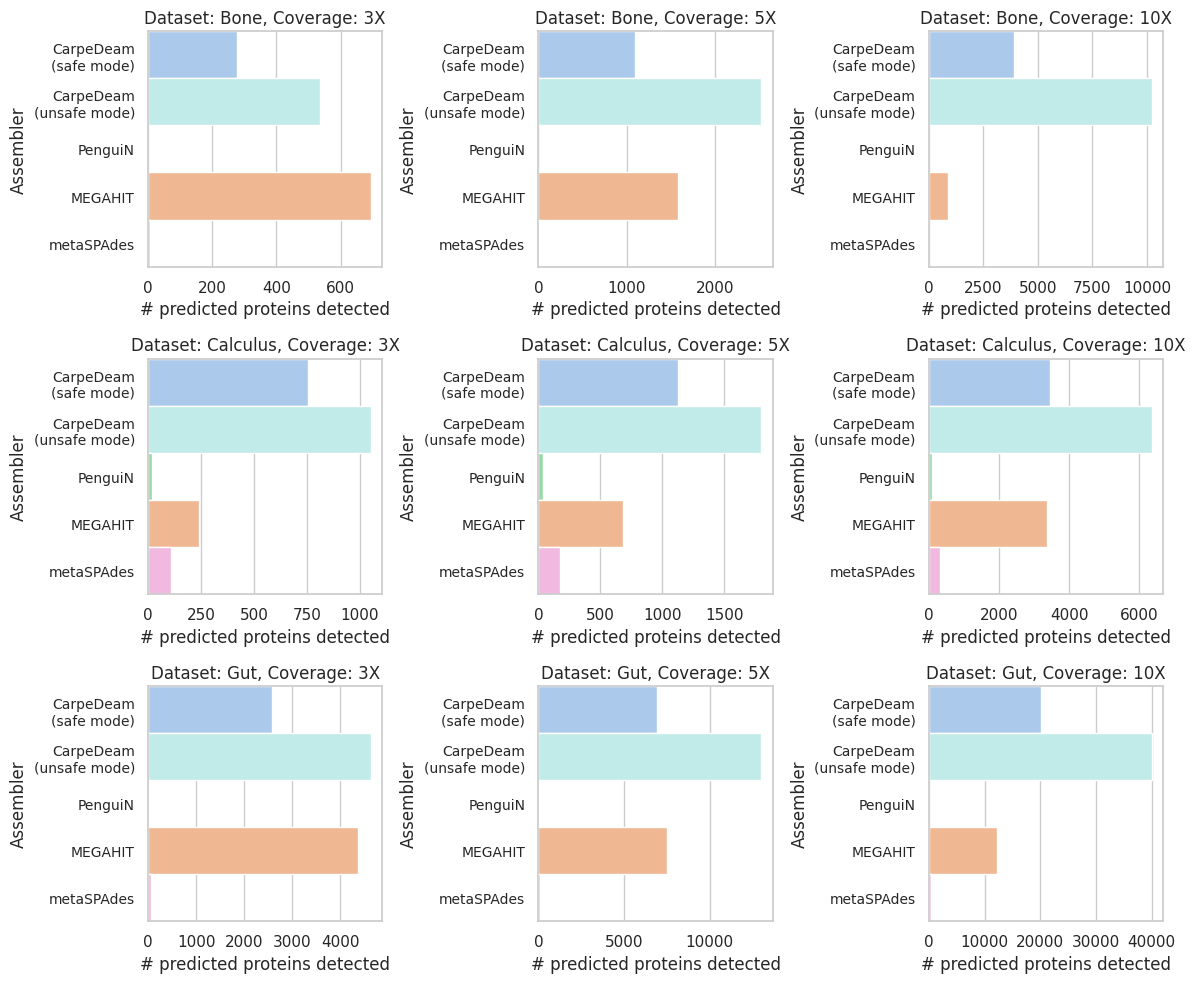

In [17]:
plot_num_correct_horizontal(protein_results, "high")